# Example usage of gw_eccentricity

Package to measure eccentricity and mean anomaly from a gravitational waveform.    
For package details, see https://pypi.org/project/gw_eccentricity. <br>
PAPER: FIXME ARIF <br>
Throughout this notebook, we refer to sections in the above PAPER for more details.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from gw_eccentricity import measure_eccentricity
from gw_eccentricity import get_available_methods
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
# to get better looking plots
use_fancy_plotsettings()

## Read the documentation
The function `measure_eccentricity` can be used to measure eccentricity and mean anomaly for given gravitational waveform data. Detail documentation for this function can be accessed using `help`.

In [2]:
help(measure_eccentricity)

Help on function measure_eccentricity in module gw_eccentricity.gw_eccentricity:

measure_eccentricity(tref_in=None, fref_in=None, method='Amplitude', dataDict=None, num_orbits_to_exclude_before_merger=2, extra_kwargs=None)
    Measure eccentricity and mean anomaly from a gravitational waveform.
    
    Eccentricity is measured using the GW frequency omega22(t) =
    dphi22(t)/dt, where phi22(t) is the phase of the (2, 2) waveform
    mode. We currently only allow time-domain, nonprecessing waveforms. We
    evaluate omega22(t) at pericenter times, t_pericenters, and build a
    spline interpolant omega22_pericenters(t) using those
    points. Similarly, we build omega22_apocenters(t) using omega22(t) at
    the apocenter times, t_apocenters.
    
    Using omega22_pericenters(t) and omega22_apocenters(t), we first
    compute e_omega22(t), as described in Eq.(4) of arxiv:xxxx.xxxx. We
    then use e_omega22(t) to compute the eccentricity egw(t) using Eq.(8)
    of arxiv:xxxx.xxxx.  M

## Load example data

As an example, we use an eccentric, equal-mass nonspinning binary black hole waveform from the SXS catalog and the corresponding zero eccentricity waveform using the NRHybSur3dq8 model.

**NOTE:** To reduce the filesize, we have created a custom file format to use here. To load waveform data using standard file format like `SXS` catalog format or `LVCNR` format or to generate waveforms using `LAL` libraries use `load_data.load_waveform` available with this package. Examples of loading different kind of waveforms can be found in the notebook `load_waveform_demo.ipynb`

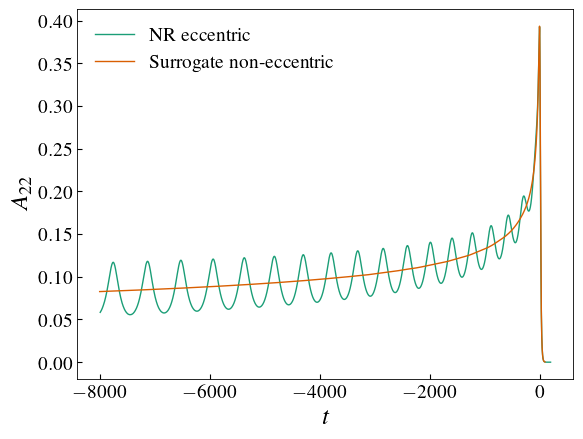

In [3]:
# Load the eccentric NR waveform and the corresponding zero-ecc surrogate waveform
f = h5py.File(f"../data/SXS_BBH_2305_22.h5", "r")
t_ecc_NR, h22_ecc_NR = f["t"][:], f["h22"][:]
t_zeroecc_sur, h22_zeroecc_sur = f["t_zeroecc"][:], f["h22_zeroecc"][:]

# Setup dataDict (Note the required format)
dataDict = {"t": t_ecc_NR,
           "hlm": {(2, 2): h22_ecc_NR},
           "t_zeroecc": t_zeroecc_sur,
           "hlm_zeroecc": {(2, 2): h22_zeroecc_sur}}
f.close()

# Plot the two waveforms
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="NR eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="Surrogate non-eccentric")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$A_{22}$");

## Usage

### Get the available methods

We implement different methods to measure eccentricity and mean anomaly.   
Recommended methods are 'AmplitudeFits' or 'ResidualAmplitude'.   
See the documentation above and Sec.III of PAPER for what different methods do.  

In [4]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'AmplitudeFits',
 'FrequencyFits']

### Measure eccentricity/mean_anomaly at reference time
`measure_eccentricity` function can be used to measure the eccentricity and mean anomaly from the waveform data in `dataDict`. The reference time can be a single time or an array of times.
`measure_eccentricity` returns a dictionary that contains the measured value of eccentricity, mean anomaly, the time at which these are measured and an object which includes methods for diagnostic plots (see below) and several internal variables.

See Sec. IIB of PAPER for details on how eccentricity and mean anomaly is defined using waveform data.

In [5]:
tref_in = -5500
for method in get_available_methods():
    return_dict = measure_eccentricity(tref_in=tref_in,
                                      method=method,
                                      dataDict=dataDict)
    tref_out = return_dict["tref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean anomaly = {mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.234925, mean anomaly = 4.915010
method = Frequency            eccentricity = 0.234893, mean anomaly = 4.915923
method = ResidualAmplitude    eccentricity = 0.234959, mean anomaly = 4.919442
method = ResidualFrequency    eccentricity = 0.234962, mean anomaly = 4.921472
method = AmplitudeFits        eccentricity = 0.234962, mean anomaly = 4.918334
method = FrequencyFits        eccentricity = 0.234962, mean anomaly = 4.921232


### Measure eccentricity/mean_anomaly at reference frequency

Eccentricity and mean anomaly can be measured at a reference frequency or an array of frequencies also.

Internally, the reference frequency $f_{\mathrm{ref}}$ is used to get reference time $t_{\mathrm{ref}}$ by first constructing an average monotonic frequency $\langle \omega_{22}\rangle$ and then demanding $\langle \omega_{22}\rangle (t_{\mathrm{ref}}) = 2\pi f_{\mathrm{ref}}$ (See Sec. IID of PAPER for how $\langle \omega_{22}\rangle$ is computed). The $t_{\mathrm{ref}}$ is then used to measured the eccentricity and mean anomaly at. 

In [6]:
fref_in = 0.005
for method in get_available_methods():
    return_dict = measure_eccentricity(fref_in=fref_in,
                                      method=method,
                                      dataDict=dataDict)
    fref_out = return_dict["fref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean anomaly = {mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.209670, mean anomaly = 3.806604
method = Frequency            eccentricity = 0.209658, mean anomaly = 3.800770
method = ResidualAmplitude    eccentricity = 0.209706, mean anomaly = 3.824476
method = ResidualFrequency    eccentricity = 0.209723, mean anomaly = 3.823542
method = AmplitudeFits        eccentricity = 0.209706, mean anomaly = 3.821522
method = FrequencyFits        eccentricity = 0.209740, mean anomaly = 3.811678


## Making diagnostic plots

We also provide methods to make diagnostic plots that can be helpful for investigations. One can simply use `gwecc_object.make_diagnostic_plots()` to make all diagnostic plots, or plot individual data pieces as shown below.

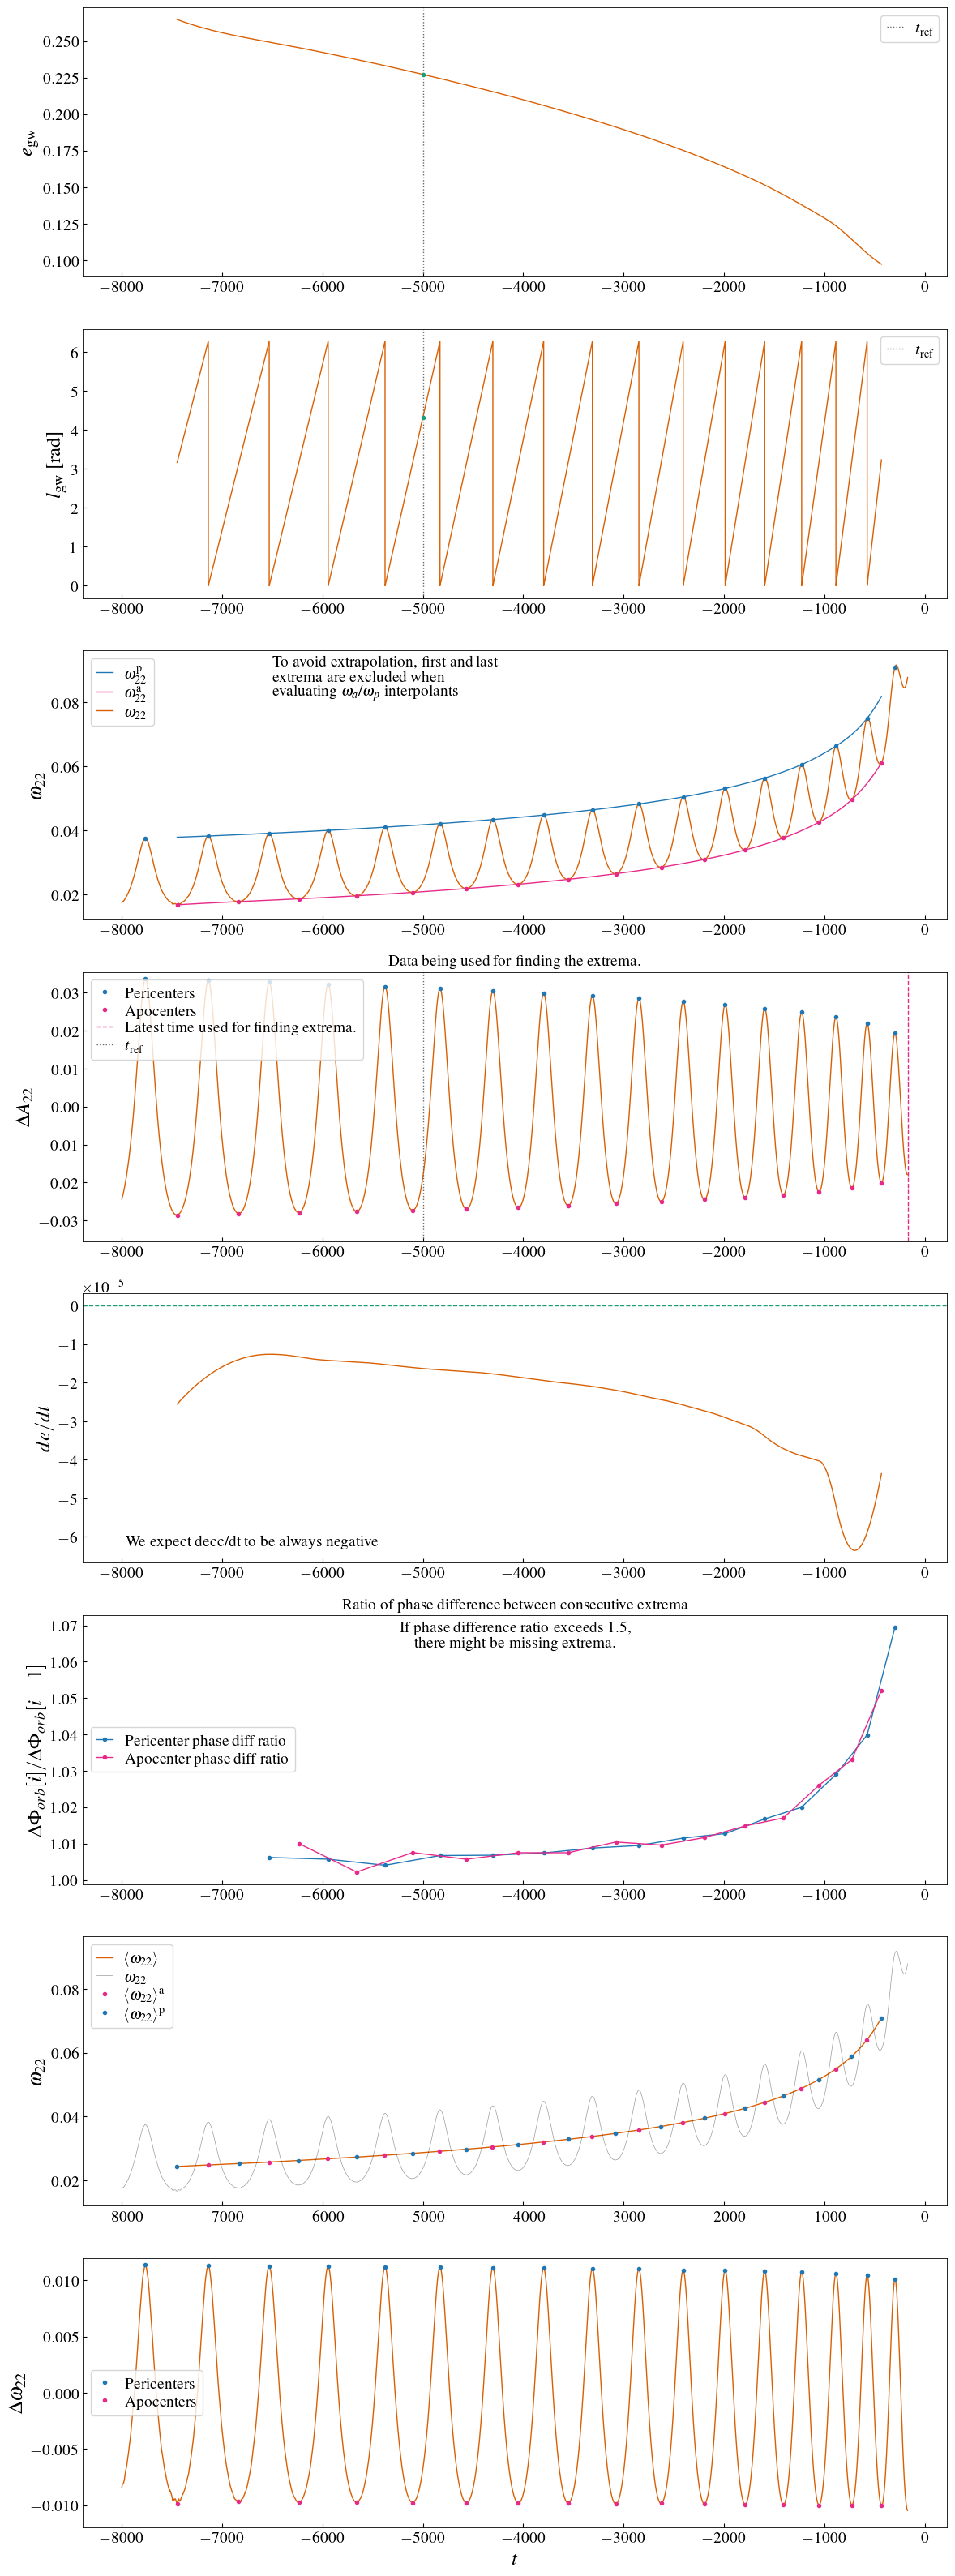

In [7]:
# Let's consider an example using ResidualAmplitude to measure eccentricity at a single time
method = "ResidualAmplitude"
tref_in = -5000
gwecc_dict = measure_eccentricity(tref_in=tref_in,
                                  method=method,
                                  dataDict=dataDict)
gwecc_object = gwecc_dict["gwecc_object"]

fig, ax = gwecc_object.make_diagnostic_plots()

### Let's look at each of these plots separately.

#### **Eccentricity vs Time:**
This plot shows the evolution of eccentricity as a function of time.

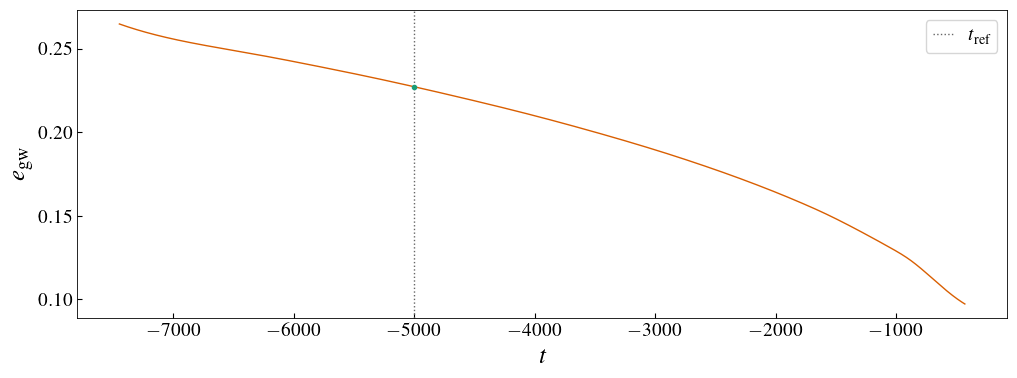

In [8]:
fig, ax = gwecc_object.plot_eccentricity()

#### **Mean anomaly vs Time:**
This plot shows the evolution of mean anomaly as a function of time

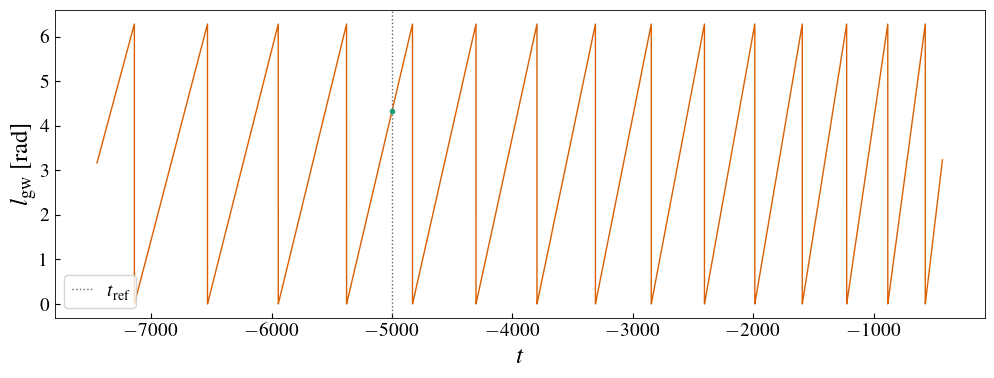

In [9]:
fig, ax = gwecc_object.plot_mean_anomaly()

#### **$\omega_{22}$ with the locations of apocenter and pericenter:**
This plot shows the $\omega_{22}(t)$ with the locations of the apocenters and pericenters that are being used for measuring eccentricity indicated by circles.<br>
This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough.

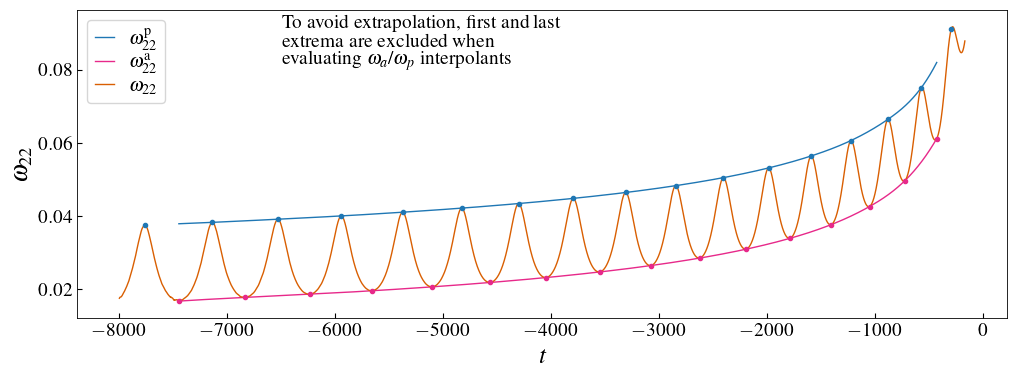

In [10]:
fig, ax = gwecc_object.plot_omega22()

#### **Data being used to find extrema:**
This plots shows the data that is used to find the locations of the extrema. Different `method` uses different data. See Sec.III of PAPER for more details.

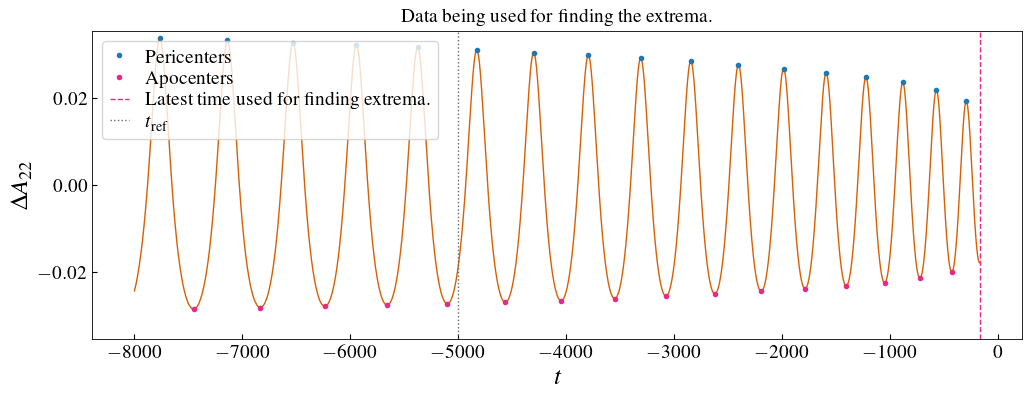

In [11]:
fig, ax = gwecc_object.plot_data_used_for_finding_extrema()

#### **$de/dt$ vs Time:**
This plot shows the first derivative of eccentricity as a function of time. The eccentricity should be a monotonically decreasing function of time. Therefore, wherever $de/dt$ becomes positive implies non-monotonic eccentricity due unphysical features.

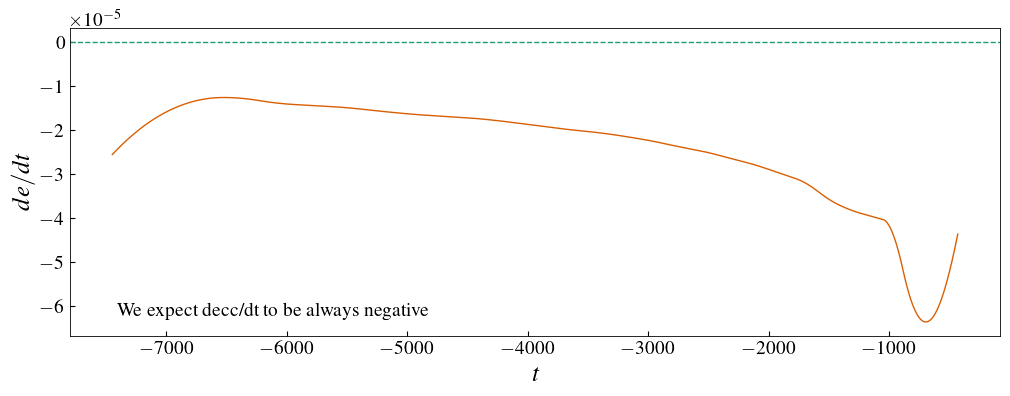

In [12]:
fig, ax = gwecc_object.plot_decc_dt()

#### **Ratio of $\Delta \phi_{\mathrm{orb}}$ between consecutive peaks/troughs vs Time:**
$\Delta \phi_{\mathrm{orb}}^{i}/\Delta \phi_{\mathrm{orb}}^{i-1}$, where $\Delta \phi_{\mathrm{orb}}^{i}$
is the change in orbital phase from the previous extrema to the ith extrema. This helps to look for missing extrema, as there will be a drastic (roughly factor of 2) change in
$\Delta \phi_{\mathrm{orb}}^{i}$ if there is a missing extrema, and the ratio will go from ~1 to ~2.

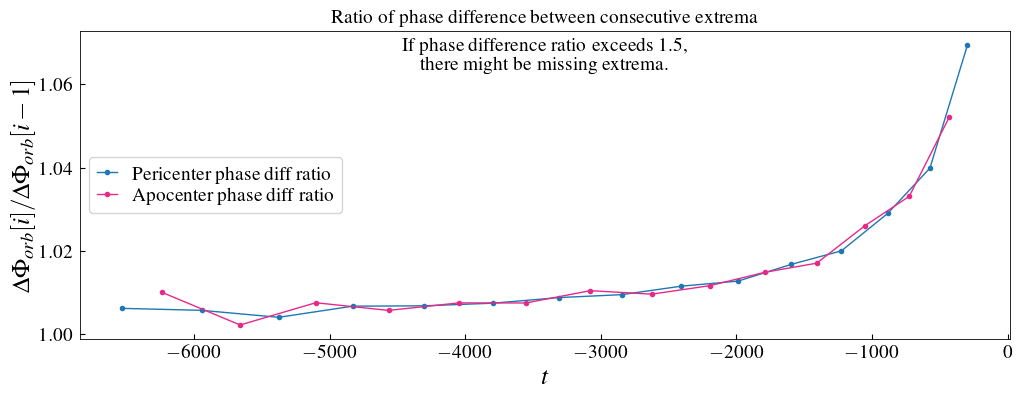

In [13]:
fig, ax = gwecc_object.plot_phase_diff_ratio_between_extrema()

#### **$\langle \omega_{22}\rangle$ vs Time:**
Average $\omega_{22}$ as a function of time. $\langle \omega_{22}\rangle$ is used to get the reference time corresponding to a given reference
frequency using $\langle \omega_{22} \rangle (t_{\mathrm{ref}}) = 2\pi f_{\mathrm{ref}}$.

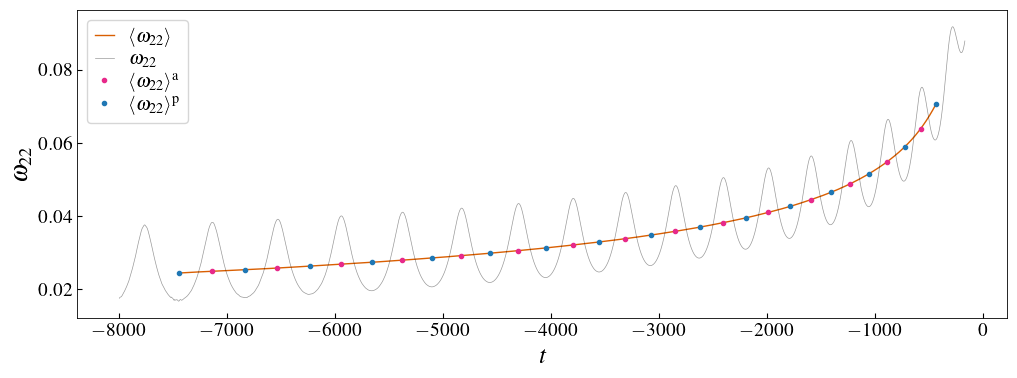

In [14]:
fig, ax = gwecc_object.plot_omega22_average()

#### **$\Delta A_{22}$ vs Time:**
$\Delta A_{22}$ is the residual amplitude of the 22 mode, defined as $\Delta A_{22} = A_{22}(e) - A_{22}(e=0)$, where we substract the 22 mode amplitude of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode amplitude of the eccentric waveform.

See Sec.IIIB in PAPER for details.

**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

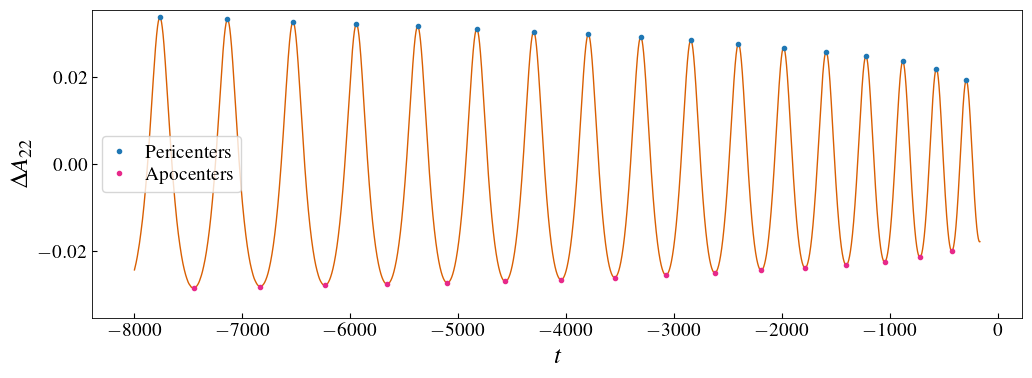

In [15]:
fig, ax = gwecc_object.plot_residual_amp22()

#### **$\Delta \omega_{22}$ vs Time:**
$\Delta \omega_{22}$ is the residual omega of the 22 mode, defined as $\Delta \omega_{22} = \omega_{22}(e) - \omega_{22}(e=0)$, where we substract the 22 mode omega of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode omega of the eccentric waveform.

See Sec. IIIB in PAPER for more details.

**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

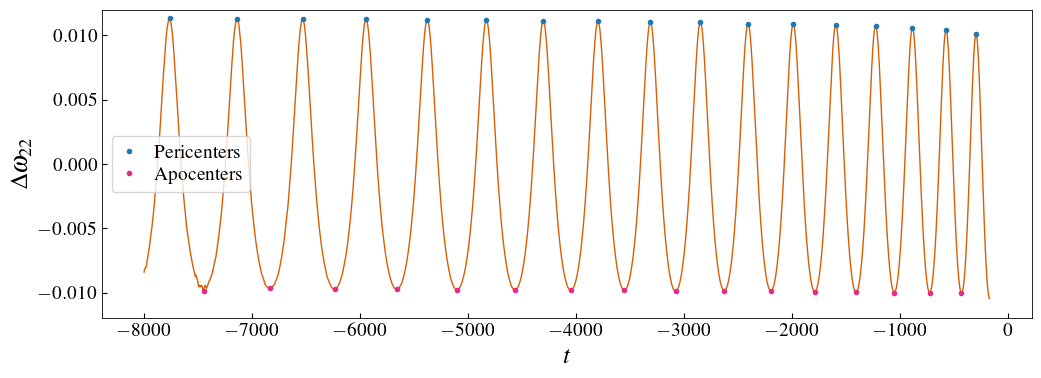

In [16]:
fig, ax = gwecc_object.plot_residual_omega22()